# ERP: Sensitivity Analysis and Surrogate Models

Sensitivity analysis and surrogate model creation predicting ERP(S1), and ERP(S1,S2) using (transformed) parameters 
$CV_{max}, \tau_{out}, APD_{max}$, with fixed $\tau_{in}$ and $\tau_{open}$.

**This notebook can be run with a hdf5 database for any parameter design (3d, 4d, 5d), so make sure to use a design with fixed $\tau_{in}$ and $\tau_{open}$ if you want the '3d input' surrogate models.**

**Make sure to run it with varying $\tau_{in}$ and $\tau_{open}$ if you want the 5d sensitivity analysis.**

The notebook used General Additive Models to do the first-order sensitivity analysis, which is fairly simple and provides a nice graphical interpretation as well.

The reason for fixing $\tau_{in}$ and $\tau_{open}$ is not that they don't have an effect on ERP, but that the effects are much smaller than the effects of $\tau_{out}$ and $APD_{max}$. We don't believe that it is possible to calibrate all of these parameters using only (two types of) ERP measurements, and previous analysis showed that it's very difficult to calibrate all 5 parameters without both CV(S2) and APD(S2), as well as ERP.

There is the catch that when $\text{ERP}(S1) > 285$ then $\text{ERP}(S1,S2)$ will be wrong because of the discontinuity in the output surface. I have exluded this region of the space in the fitting. So, remember to return NaN results for the surrogates if ERP(S1) > 285, since ERP(S1,S2) will be wrong in this case.


In [1]:
# pick database to use
# --------------------

# my modules
import mmserp.hdf5utils as hu
import pkg_resources

#datafile = '5d_500.hdf5'
datafile = '3d_100.hdf5'

table_filename = pkg_resources.resource_filename('mmserp', 'data/' + datafile )

S1 = 600

FIGDIR = "/tmp/" + datafile.split('.')[0] + "_"
FIGDIR

'/tmp/3d_100_'

In [2]:
# load modules
# ------------

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
from matplotlib import cm
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

from pygam import LinearGAM, te, ExpectileGAM
from pygam import s as spline



# notebook settings
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
    
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

/tmp/ipykernel_204440/1382218978.py:15: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  from mpl_toolkits.axes_grid1.colorbar import colorbar


In [3]:
# MMS modeling functions
# ----------------------

v_gate = 0.1 # fixed parameter

def paramsToFeatures(data):
    """Convert from MMS parameters to 'features', accounting for feature being tau_out"""
    
    D, t_in, t_out, t_open, t_close = [d for d in data.T]
    h_min = 1 / ( 1 + t_out/(4*t_in) * (1 - v_gate)**2 )
    APD_max = t_close * np.log( 1.0 / h_min )
    CV_max = 0.5 * (1 - 2*v_gate) * np.sqrt(2*D/t_in)
    return np.hstack([ CV_max[:,None], t_in[:,None], t_out[:,None], t_open[:,None], APD_max[:,None] ])

def featuresToParams(data):
    """Convert from MMS 'features' to parameters, accounting for feature being tau_out"""
    
    CV_max, t_in, t_out, t_open, APD_max = [d for d in data.T]
    D = 0.5*t_in * ( 2*CV_max / (1 - 2*v_gate) )**2
    h_min = 1 / ( 1 + t_out/(4*t_in) * (1 - v_gate)**2 )
    t_close = -APD_max / np.log(h_min)
    return np.hstack([ D[:,None], t_in[:,None], t_out[:,None], t_open[:,None], t_close[:,None] ])


In [4]:
# load the simulation results
# ---------------------------

params = hu.getDataset(table_filename, "/", "params")
print("loaded", params.shape[0], "rows")
all_data_S1S2 = hu.getDataset(table_filename, str(S1), "0")
all_data_S1S2S3 = hu.getDataset(table_filename, str(S1), "300")


table_CV = all_data_S1S2[:,0]
table_APD = all_data_S1S2[:,1]
table_ERP = all_data_S1S2[:,2]
CVrest    = all_data_S1S2[:,[3,4,5]]
APDrest   = all_data_S1S2S3[:,[6,7,8]]
newERP    = all_data_S1S2S3[:,2]

features = paramsToFeatures(params)


# filter out various rows of data
# -------------------------------

# filter out NaN results
condition = ~( ( np.isnan(CVrest) | np.isnan(APDrest) ).any(1) | \
               (table_ERP > 600) | np.isnan(table_ERP) \
             )
print("condition:", condition.sum())

# filter out extreme outliers
med = np.nanmedian(APDrest, axis = 0)
mad = np.nanmedian(np.abs(APDrest - med), axis = 0)
outliers_APD = ( (APDrest < (med - 6*mad)) | (APDrest > (med + 6*mad)) ).any(1)

# filter out extreme outliers
med = np.nanmedian(CVrest, axis = 0)
mad = np.nanmedian(np.abs(CVrest - med), axis = 0)
outliers_CV = ( (CVrest < (med - 6*mad)) | (CVrest > (med + 6*mad)) ).any(1)

outliers = outliers_APD | outliers_CV
#print("outliers:", outliers)
    
condition = condition * ~outliers
print("condition discarding outliers:", condition.sum())

# enforce reasonable ERP(S1)
condition = condition * (table_ERP < 285) * (table_ERP > 160)
print("condition discarding outliers and bad ERP:", condition.sum())


params, features = params[condition], features[condition]
table_CV, table_ERP, table_APD, newERP = table_CV[condition], table_ERP[condition], table_APD[condition], newERP[condition]
CVrest, APDrest = CVrest[condition], APDrest[condition]

# also, stack ERP together
both_ERP = np.hstack([table_ERP[:,None], newERP[:,None]])


loaded 100 rows
condition: 77
condition discarding outliers: 74
condition discarding outliers and bad ERP: 61


### Note on ERP range

Note that there is a discontinuity in the ERP(S1,S2) output surface (as a function of $\tau_{out}, APD_{max}$ that occurs for $ERP(S1) \geq 285$, so the restriction of $ERP(S1)$ above is very helpful. Furthermore, experiments on ERP find the range to be mostly 160 - 280 (in fact, usually 170 - 270), so this is also realistic.

The figure below shows that these two ERP values have a decent spread i.e. learning about one type of ERP does not tell you everything you need to know about the other. Therefore they correspond to different properties.

I have found that even S2 320ms seems to correlate these two ERP measurements much more i.e. it prevents probing different tissue properties.

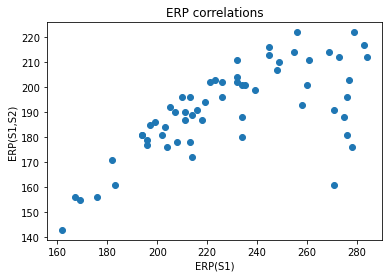

In [5]:
# ERP(S1) vs ERP(S1, S2) correlation
# ----------------------------------

fig = plt.figure()
plt.scatter(table_ERP, newERP)
plt.xlabel("ERP(S1)")
plt.ylabel("ERP(S1,S2)")
plt.title("ERP correlations")
plt.show()

## Coefficient of correlation betwen ERP and APD

Can calculate this for the paper.


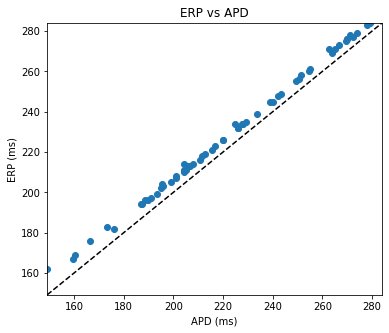

In [6]:
# ERP vs APD consideration

fig = plt.figure(figsize = (6,5))

plt.title("ERP vs APD")
plt.xlabel("APD (ms)")
plt.ylabel("ERP (ms)")

plt.scatter(table_APD, table_ERP)

MIN = np.min( [np.min(table_APD), np.min(table_ERP)] )
MAX = np.max( [np.max(table_APD), np.max(table_ERP)] )
plt.xlim(MIN, MAX)
plt.ylim(MIN, MAX)
plt.plot(np.array([MIN, MAX]), np.array([MIN, MAX]), color = "black", linestyle = "--")

plt.show()


## Transformed parameter space

The scatter plots below use the new transformed parameters (I have already fixed $\tau_{in}$ and $\tau_{open}$ for this notebook). 

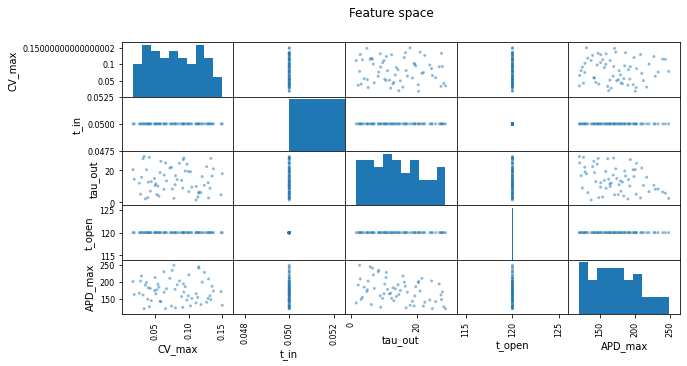

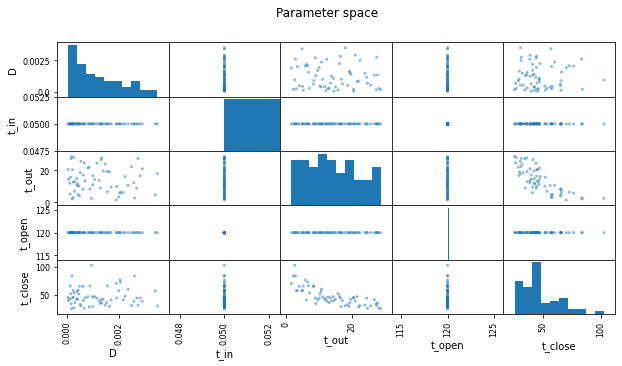

In [7]:
# visualize the parameter/features space from our simulation table using a grid.

# feature space
DF = pd.DataFrame(features, columns = ["CV_max", "t_in", "tau_out", "t_open", "APD_max"])
axarr = pd.plotting.scatter_matrix(DF, alpha = 0.5, diagonal = "hist", range_padding = 0.25, figsize  = (10,5)) 
plt.suptitle("Feature space")
plt.show()

# parameter space
DF = pd.DataFrame(params, columns = ["D", "t_in", "t_out", "t_open", "t_close"])
axarr = pd.plotting.scatter_matrix(DF, alpha = 0.5, diagonal = "hist", range_padding = 0.25, figsize  = (10,5)) # ,\
plt.suptitle("Parameter space")
plt.show()

## GAM sensitivity

In [8]:
# params/features vs PCA coefficients
# -----------------------------------

def calcSensitivity(table_coeffs, features, EXPECTILES = True, COLORS = ["turquoise", "cornflowerblue", "orchid"]):
    """Calculate sensitivity via GAM models, and make main effects plots."""

    param_names = ["D", "Tin", "Tout", "Topen", "Tclose"]
    feature_names = ["CVmax", "Tin", "Tout", "Topen", "APDmax"]

    PCA_COLOR = COLORS

    # sensitivity calculation with main effects plots
    # -----------------------------------------------
    
    # store sensitivity in table (rows: outputs, columns: MMS features (or parameteres))
    sensitivity = np.zeros((table_coeffs.shape[1], features.shape[1]))

    # features
    fig, ax = plt.subplots(table_coeffs.shape[1], 5, figsize = (10,2.5*table_coeffs.shape[1]))

    for i in range(table_coeffs.shape[1]): # PCA coefficient loop
        for j in range(5): # parameter/feature loop

            X = features[:,[j]]
            if i < table_coeffs.shape[1]:
                Y = table_coeffs[:,i]
                subtitle = "PC {:d}".format(i + 1)
                color = PCA_COLOR[i]

            ax[i,j].scatter(X, Y, alpha = 0.25, color = "gray")
            
            
            # -------- GAM model -------- START
            N_SPLINES = 50
            if EXPECTILES == False: # mean
                gam = LinearGAM(n_splines = N_SPLINES).gridsearch(X, Y, progress = False)
            else: # expectiles
            
                gam = ExpectileGAM(n_splines = N_SPLINES, expectile=0.5).gridsearch(X, Y, progress = False)
                lam = gam.lam
                gam05 = ExpectileGAM(n_splines = N_SPLINES, expectile=0.05, lam=lam).fit(X, Y)
                gam95 = ExpectileGAM(n_splines = N_SPLINES, expectile=0.95, lam=lam).fit(X, Y)
            
            XX = gam.generate_X_grid(term=0, n=500)
            gam_mean = gam.predict(XX)

            ax[i,j].plot(XX, gam_mean, c = color, lw = 4)
            if EXPECTILES == False: # mean
                gam_CI = gam.prediction_intervals(XX, width=.95)
                ax[i,j].plot(XX, gam_CI, c = color, lw = 2, ls = "--")
            else: # expectiles
                ax[i,j].plot(XX, gam05.predict(XX), c = color, lw = 2, ls = "--")
                ax[i,j].plot(XX, gam95.predict(XX), c = color, lw = 2, ls = "--")


            # calculate sensitivity from the GAM model
            sensitivity[i, j] = gam.predict(X).var() / Y.var()
            
            # -------- GAM model -------- END

            
            # ensure that the range is correct; set from data not fits
            # --------------------------------------------------------
            x_buff, y_buff = X.std()/2, Y.std()/2
            x_buff = 0.0
            ax[i,j].set_xlim([X.min() - x_buff, X.max() + x_buff])
            ax[i,j].set_ylim([Y.min() - y_buff, Y.max() + y_buff])


            # remove some ticks for nicer plots
            # ---------------------------------

            if i == table_coeffs.shape[1] -1:
                ax[i,j].set_xlabel(feature_names[j])
            else:
                ax[i,j].set_xticks([])

            if j == 0:
                ax[i,j].set_ylabel(subtitle)
            else:
                ax[i,j].set_yticks([])

    # force range of plot to be correct
    for a in ax.flat:
        a.set(adjustable='box', aspect='equal')
        x0,x1 = a.get_xlim(); y0,y1 = a.get_ylim()
        a.set_aspect((x1-x0)/(y1-y0))
        #a.set_xticks([]); a.set_yticks([]); 

    plt.tight_layout()
    plt.show()

    return sensitivity


In [9]:

def plot_sensitivity_new(sensitivity, legend, COLORS = ["turquoise", "cornflowerblue", "orchid"], title = None):
    """ Sensitivity plots.
        Pass the sensitivity rows that you want and a corresponding LIST of legend labels for them.
    """

    # ---- bar style ---- #
    HATCH = ["", "//", '..']
    #COLORS = ["turquoise", "cornflowerblue", "orchid"]
    labels = ["CVmax", "Tin", "Tout", "Topen", "APDmax"]
    x = np.arange(len(labels))  # the label locations
    width = 0.2
    
    factor = 1.25 if len(legend) == 3 else 0.65
        
    fig, ax = plt.subplots(figsize = (6.5,3))
    
    if sensitivity.ndim < 3: sensitivity = sensitivity[None,:,:] # then it must be both S1 and ST
    
    for ss in range(sensitivity.shape[0]):
    
        alpha = 0.5 if (ss == 0 and sensitivity.shape[0] > 1) else 1.0
    
        for EE, E in enumerate(legend):

            offset = (EE-1)*width*factor
            if EE == 1 and len(legend) == 2: offset = (1)*width*factor

            ax.bar(x + offset, sensitivity[ss, EE, :], width, label = E if (ss == 1 or sensitivity.shape[0] == 1) else None,\
                   color = COLORS[EE], hatch = HATCH[EE], alpha = alpha)
            
            
    ax.set_xticks(x)
    ax.set_xticklabels(labels = labels, rotation = 20)
    #ax.tick_params(axis='x', which='major', pad=15)

    plt.ylabel("Sensitivity Index")

    #plt.tight_layout()
    plt.ylim(0,1)
    plt.legend(loc = "upper center", ncol = 3)
    
    # plotting
    plt.savefig(FIGDIR + "single_sens.pdf", bbox_inches = 'tight', pad_inches = 0.05)
    plt.show()
    
    return


__ERP scatter and GAM__

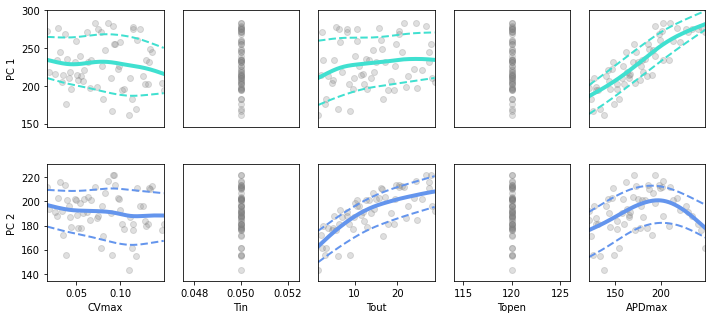

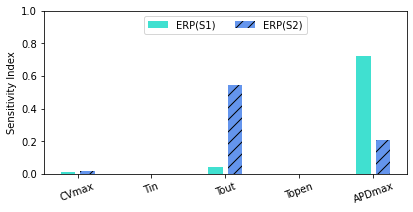

In [10]:
printmd("__ERP scatter and GAM__")

sensitivity_ERP = calcSensitivity(both_ERP, features)
plot_sensitivity_new(sensitivity_ERP, legend = ["ERP(S1)", "ERP(S2)"], title = "ERP")


## Surrogate models

Summary:
* ERP (both types) uses a cubic polynomial of $\tau_{out}, APD_{max}$ i.e. 10 terms
* CV uses quadratic of $\sqrt{CV_{max}}$ i.e. 3 terms


In [11]:
# dictionary to store coefficients arrays

coeffs_dict = {}


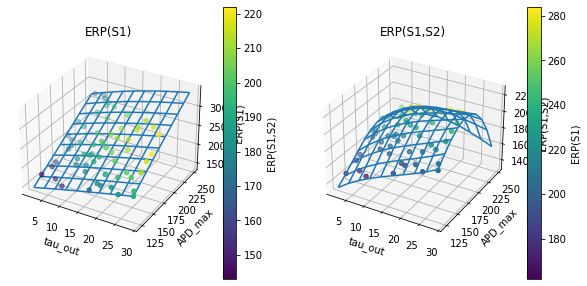

In [12]:
# fit the models for ERP
# ----------------------

# cubic basis
X = np.hstack([np.ones_like(table_ERP), features[:,2], features[:,4],\
               features[:,2]**2, features[:,4]**2, features[:,2]*features[:,4],\
               features[:,2]**3, features[:,4]**3, features[:,2]**2*features[:,4], features[:,2]*features[:,4]**2,
              ]).reshape(10,-1).T

fig = plt.figure(figsize = (10,5))

for i in [1,2]:

    if i == 1: Y = table_ERP
    if i == 2: Y = newERP
        
    # fit model
    res = np.linalg.lstsq(X, Y, rcond = None)
    coeffs = res[0]
    
    coeffs_dict["ERPS" + str(i)] = coeffs


    # plot the surrogate model
    # ------------------------

    X1 = np.linspace(features[:,2].min(), features[:,2].max(), 10, endpoint = True)
    X2 = np.linspace(features[:,4].min(), features[:,4].max(), 10, endpoint = True)

    X1, X2 = np.meshgrid(X1, X2)

    Z = coeffs[0] + coeffs[1]*X1 + coeffs[2]*X2 \
      + coeffs[3]*X1**2 + coeffs[4]*X2**2 + coeffs[5]*X1*X2 \
      + coeffs[6]*X1**3 + coeffs[7]*X2**3 + coeffs[8]*X1**2*X2 + coeffs[9]*X1*X2**2

    ax = fig.add_subplot(1, 2, i, projection='3d')

    C = newERP if i == 1 else table_ERP
    p = ax.scatter(features[:,2], features[:,4], Y, c = C)
    surf = ax.plot_wireframe(X1, X2, Z)
    title = "ERP(S1)" if i == 1 else "ERP(S1,S2)"

    ax.set_xlabel('tau_out')
    ax.set_ylabel('APD_max')
    ax.set_zlabel(title)

    cb = plt.colorbar(p)
    cb_title = "ERP(S1,S2)" if i == 1 else "ERP(S1)"
    cb.set_label(cb_title)
    
    plt.title(title)
    
plt.show()



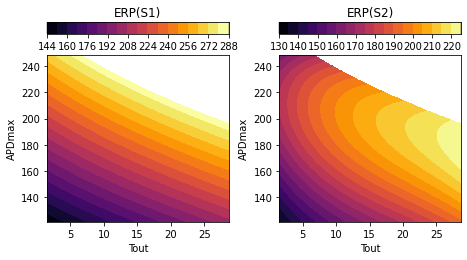

In [25]:
# fit the models for ERP
# ----------------------

    
fig=plt.figure(figsize=(6.6,3.5))
gs=GridSpec(1,2) # 2 rows, 3 columns


# cubic basis
X = np.hstack([np.ones_like(table_ERP), features[:,2], features[:,4],\
               features[:,2]**2, features[:,4]**2, features[:,2]*features[:,4],\
               features[:,2]**3, features[:,4]**3, features[:,2]**2*features[:,4], features[:,2]*features[:,4]**2,
              ]).reshape(10,-1).T


#fig, axs = plt.subplots(1,2,figsize = (8,4), sharey = True)

for i in [0,1]:

    if i == 0: Y = table_ERP
    if i == 1: Y = newERP
        
    # fit model
    res = np.linalg.lstsq(X, Y, rcond = None)
    coeffs = res[0]
    
    coeffs_dict["ERPS" + str(i + 1)] = coeffs


    # plot the surrogate model
    # ------------------------

    X1 = np.linspace(features[:,2].min(), features[:,2].max(), 200, endpoint = True)
    X2 = np.linspace(features[:,4].min(), features[:,4].max(), 200, endpoint = True)

    X1, X2 = np.meshgrid(X1, X2)

    Z = coeffs[0] + coeffs[1]*X1 + coeffs[2]*X2 \
      + coeffs[3]*X1**2 + coeffs[4]*X2**2 + coeffs[5]*X1*X2 \
      + coeffs[6]*X1**3 + coeffs[7]*X2**3 + coeffs[8]*X1**2*X2 + coeffs[9]*X1*X2**2

    if i == 0: Z_ERPS1 = Z.copy()
    
    Z = np.ma.array(Z, mask = (Z_ERPS1 > 285))
    
    ax = fig.add_subplot(gs[0,i]) # changed
    C = Y 
    #p = ax.scatter(features[:,2], features[:,4], Y, c = C)
    
    if i == 0: vmin, vmax = None, 285
    if i == 1: vmin, vmax = None, None
    surf = ax.contourf(X1, X2, Z, levels = 20, vmin = vmin, vmax = vmax, cmap = "inferno")
    title = "ERP(S1)" if i == 0 else "ERP(S2)"

    
    ax.set_xlabel('Tout')
    ax.set_ylabel('APDmax')

    # Label levels with specially formatted floats
    if plt.rcParams["text.usetex"]:
        fmt = r'%r'
    else:
        fmt = '%r'

    ax_divider = make_axes_locatable(ax)
    cbax = ax_divider.append_axes("top", size="7%", pad="12.5%")
        
    cb = colorbar(surf, orientation="horizontal", cax = cbax)
    #cbax.xaxis.set_ticks_position("top")
    cb_title = "ERP(S2)" if i == 1 else "ERP(S1)"
    #cb.set_label_text(cb_title, pad = "20%")
    
    #ax.set_aspect()
    
    fig.subplots_adjust(wspace=0.125, hspace=0)
    
    plt.title(title)
    
plt.tight_layout()
plt.savefig(FIGDIR + "contours.pdf", bbox_inches = 'tight', pad_inches = 0.05)
plt.show()


In [17]:
# define a single surrogate model
# -------------------------------

## Save surrogate coefficients into npz file
np.savez(FIGDIR + "surrogate_coefficients.npz", 
         coeffs_ERPS1 = coeffs_dict["ERPS1"],
         coeffs_ERPS2 = coeffs_dict["ERPS2"])


In [15]:
coeffs_ERPS1 = coeffs_dict["ERPS1"]
coeffs_ERPS2 = coeffs_dict["ERPS2"]

def surrogate(tau_out, APD_max):
    """Example surrogate function..."""
    
    ERP_basis = np.hstack([1, # constant
                           tau_out, APD_max, # linear
                           tau_out**2, APD_max**2, tau_out*APD_max, # quadratic
                           tau_out**3, APD_max**3, tau_out**2*APD_max, tau_out*APD_max**2] # cubic
                         )
    
    ERPS1 = np.dot(coeffs_ERPS1, ERP_basis)
    ERPS2 = np.dot(coeffs_ERPS2, ERP_basis)

    # NOTE: returning NaNs remind me where to mistrust the surrogate for ERP(S2)
    return [ERPS1, ERPS2] if ERPS1 <= 285 else [np.nan, np.nan]

res = surrogate(10, 200)
res

[245.99982235433143, 199.99408044040274]

# The end
